In [43]:
import pandas as pd
import networkx as nx
import math
import matplotlib.pyplot as plt
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.centrality import eigenvector_centrality, closeness_centrality
from networkx.algorithms.distance_measures import diameter

In [151]:
def get_network(df, from_hashtag=""):
    ''' returns a dataframe with the edges and timestamp from tweets feed (df)'''
    
    if from_hashtag != "":
        mask = df["hashtags"].apply(lambda x: from_hashtag.lower() in x)
        filteredDf = df[mask]
    else:
        filteredDf = df

    edges_df = filteredDf[['screen_name', 'to', 'created_at', 'text', 'followers_count', 'friends_count', 'favourites_count', 'retweet_count']]
    edges_df = edges_df.rename(columns={'screen_name': 'from'})
    edges_df = edges_df.explode('to')
    edges_df = edges_df.explode('to').reset_index(drop=True)
    
    G = nx.from_pandas_edgelist(edges_df, 'from', 'to', ["followers_count", "friends_count", "favourites_count", "retweet_count", "created_at"], create_using=nx.DiGraph())

    return G

# takes our main dataset and combines `reply_to_screen_name` and `mentions` from tweets
# into a single `to` column
# also drops tweets that don't have any mentiosn ore replying to someone
# this should ALWAYS be used to get our primary data for the dataset
def transform_df(df):
    edges_df = df[['screen_name', 'reply_to_screen_name', 'created_at', 'hashtags', 'mentions', 'followers_count', 'friends_count', 'text', 'is_quote', 'is_retweet', 'favourites_count', 'retweet_count', 'country_code', 'verified', 'lang']]

    edges_df["hashtags"] = edges_df["hashtags"].apply(lambda x: ",".join(x))
    edges_df["mentions"] = edges_df["mentions"].apply(lambda x: ",".join(x))
    
    edges_df["reply_to_screen_name"] = edges_df["reply_to_screen_name"].fillna("")
    edges_df["reply_to_screen_name"] = edges_df["reply_to_screen_name"].apply(lambda x: "@" + x if x != "" else "")

    edges_df["to"] = edges_df["reply_to_screen_name"] + "," + edges_df["mentions"]
    edges_df["to"] = edges_df["to"].fillna("")

    edges_df["to"] = edges_df["to"].apply(lambda x: ",".join(list(set(x.split(",")))))
    edges_df["to"] = edges_df["to"].apply(lambda x: x[1:] if len(x)>0 and x[0]=="," else x)

    edges_df = edges_df.drop(["reply_to_screen_name", "mentions"], axis=1)
    edges_df["country_code"] = edges_df["country_code"].fillna("")

    noReplyFilter = edges_df["to"] != ""
    edges_df = edges_df[noReplyFilter]

    noRTFilter = edges_df["is_retweet"] != True
    edges_df = edges_df[noRTFilter]

    onlyEnglishFilter = edges_df["lang"] == "en"
    edges_df = edges_df[onlyEnglishFilter]

    rTfilters = edges_df["retweet_count"] >= 50
    edges_df = edges_df[rTfilters]

    likefilters = edges_df["favourites_count"] >= 50
    edges_df = edges_df[likefilters]

    edges_df = edges_df.drop_duplicates().reset_index(drop=True)

    return edges_df

def print_basic_stats(network):
    print("Number of nodes: " + str(network.number_of_nodes()))
    print("Number of edges: " + str(network.number_of_edges()))
    print("Average clustering coefficient: " + str(average_clustering(network)))

    G_deg = nx.degree_histogram(G)
    G_deg_sum = [a * b for a, b in zip(G_deg, range(0, len(G_deg)))]
    print('Average degree: {}'.format(sum(G_deg_sum) / G.number_of_nodes()))

    dirNet = network.to_undirected()
    print("Network diameter: " + str(diameter(dirNet)))
    # print("Eigenvector centrality: " + str(eigenvector_centrality(network)))
    # print("Closeness centrality: " + str(closeness_centrality(network)))

def create_gephi_from_network(network, name):
    nx.write_gexf(network, "./gephis/" + name + "-network.gexf")

def get_strongly_gcc(G):
    """ get the giant strongly connected component of G""" 
    SGcc = max(nx.strongly_connected_components(G), key=len)
    SGcc = G.subgraph(SGcc)
    return SGcc

def get_weakly_gcc(G):
    """ get the giant weakly connected component of G"""  
    WGcc = max(nx.weakly_connected_components(G), key=len)
    WGcc = G.subgraph(WGcc)
    return WGcc
   

def plot_network(G, G_degree=None, outputname="default", color="turquoise", n_color="blue"):
    ''' plot the graph with varying nodesize '''
    
    fig = plt.figure(num=None, figsize=(15, 15), dpi=60, facecolor='b', edgecolor='k')
    pos = nx.spring_layout(G)
    
    if G_degree:
        node_size=[v * 10 for v in dict(G_degree).values()]
    else:
        node_size = 1
        
    nx.draw(G, pos, nodelist=dict(G_degree).keys(), node_size=node_size, width=0.5, alpha=0.5, edge_color=color, node_color=n_color)
    plt.axis('off')
    plt.show()
    fig.savefig("./viz/" +outputname + "-network.svg", transparent=True)

In [143]:
# when we merge dataset and put it in csv, these no longer retain their original types
# so we need the converters + eval to bring their original form back basically
df = pd.read_csv('data/merged-dataset.csv', converters={"hashtags": eval, "mentions": eval, "is_quote": eval}) 
# df.columns

In [66]:
# df    

In [144]:
df = transform_df(df)

<ipython-input-142-8c51f947ff3a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["hashtags"] = edges_df["hashtags"].apply(lambda x: ",".join(x))
<ipython-input-142-8c51f947ff3a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["mentions"] = edges_df["mentions"].apply(lambda x: ",".join(x))
<ipython-input-142-8c51f947ff3a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [145]:
df

screen_name            created_at  \
0            RonniSalt  2020-03-29T00:00:29Z   
1          CPHO_Canada  2020-03-29T00:03:14Z   
2              RVAwonk  2020-03-29T00:03:41Z   
3           byQueenVic  2020-03-29T00:07:37Z   
4      ChristinePolon1  2020-03-29T00:07:45Z   
...                ...                   ...   
23111      CPHO_Canada  2020-04-30T23:49:51Z   
23112        holmescnn  2020-04-30T23:50:12Z   
23113   OnTheRedCarpet  2020-04-30T23:53:12Z   
23114    SenatorDurbin  2020-04-30T23:54:13Z   
23115       thecableng  2020-04-30T23:58:51Z   

                                                hashtags  followers_count  \
0                                                covid19            27898   
1      publichealth,physicaldistancing,covid19,stayho...           136733   
2                                                covid19           437022   
3                                            coronavirus            47206   
4                                  coronavirus,washhands            37473   
...                                                  ...              ...   
23111             covid19,physicaldistancing,handwashing           189620   
23112                            trump,coronavirus,china            22961   
23113                          covid19,queen,adamlambert            58594   
23114                                            covid19           658190   
23115                                            covid19           483813   

       friends_count                                               text  \
0               3544  Good to see the Prime Minister's buddy out the...   
1                182  2/4 A note of cautious optimism from British C...   
2               3703  CDC is denying a rumor that the agency is prep...   
3               3800  Prince William and Kate have described the las...   
4               6892  Still no one at my local Walmart sick that wor...   
...              ...                                                ...   
23111            182  4/5 While we are eager to get out of our house...   
23112           2451  #Trump contradicts US intel community by claim...   
23113           1178  YOU are the Champions🎶 @QueenWillRock and @ada...   
23114           2366  .@SenateDems are ready to go back to work next...   
23115           3888  PHOTOS: Humans hide behind rams inside lorries...   

       is_quote  is_retweet  favourites_count  retweet_count country_code  \
0         False       False            225775            137                
1         False       False               530            141                
2          True       False             90581            168                
3         False       False              6222             72                
4         False       False            274262             64                
...         ...         ...               ...            ...          ...   
23111     False       False               541             54                
23112     False       False              3022            167                
23113     False       False             13496             56                
23114     False       False               576             83                
23115     False       False              2252             72                

       verified lang                                           to  
0         False   en                             @ScottMorrisonMP  
1          True   en                                 @CPHO_Canada  
2         False   en                                      @CDCgov  
3          True   en                                      @PHE_uk  
4         False   en                             @realDonaldTrump  
...         ...  ...                                          ...  
23111      True   en                                 @CPHO_Canada  
23112      True   en  @ZcohenCNN,@Acosta,@kylieatwood,@MarquardtA  
23113      True   en             @QueenWillRock,@WHO,@adamlambert  
231

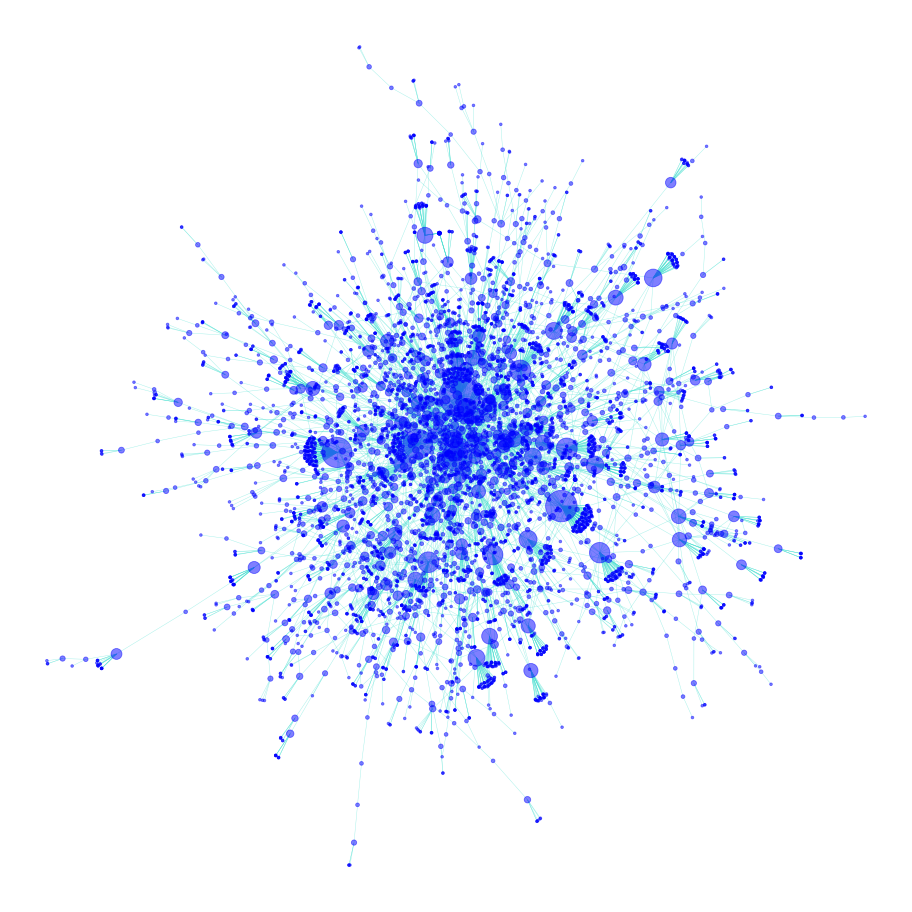

In [155]:
hashtag = "COVID19"
G = get_network(df, hashtag)
Gcc = get_weakly_gcc(G)
Gcc = Gcc.to_undirected()
Gcc_degree = Gcc.degree()

plot_network(Gcc, Gcc_degree, hashtag)


In [57]:
whole_network_graph = get_network(df)
G = nx.from_pandas_edgelist(whole_network_graph, 'from', 'to', create_using=nx.DiGraph())

weightDf = pd.DataFrame(dict(G.degree()).items(), columns=['user', 'degree'])
weightDf.sort_values(by="degree", inplace=True, ascending=False, ignore_index=True)
len(whole_network_graph)

15262

In [26]:
mentionDf = pd.DataFrame(dict(whole_network_graph.to.value_counts()).items(), columns=['user', 'num_replies_rcvd'])
mentionDf

user  num_replies_rcvd
0     realDonaldTrump               721
1          DiazCanelB               645
2         DeZurdaTeam               541
3       Maryam_Rajavi               127
4          WhiteHouse                99
...               ...               ...
7108             AARP                 1
7109       AHindinews                 1
7110     charms_india                 1
7111          choo_ek                 1
7112  everaldomarques                 1

[7113 rows x 2 columns]

In [27]:
combined = pd.concat([weightDf, mentionDf["num_replies_rcvd"]], axis=1)
combined = combined[0:10]

<AxesSubplot:xlabel='user'>

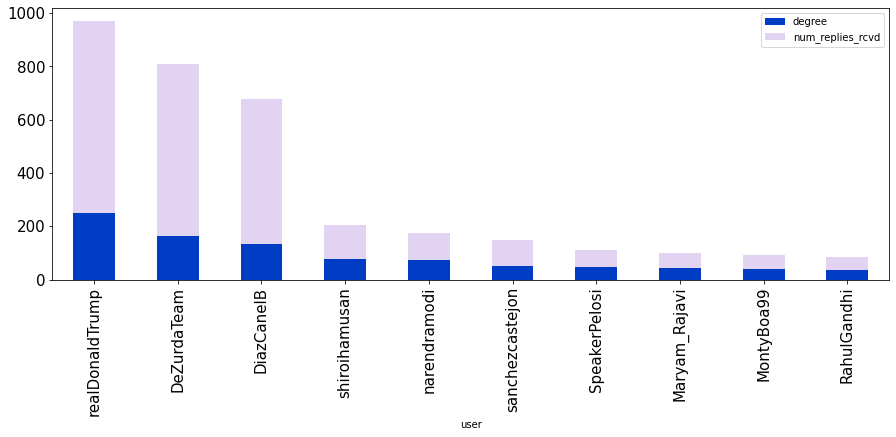

In [149]:
combined.plot.bar(stacked=True, x="user", figsize=(15,5), fontsize=15, color=["#013DC4", "#E2D3F3"])

In [52]:
print_basic_stats(G)

Number of nodes: 14632
Number of edges: 12383
Average clustering coefficient: 0.0035804306284722377
Average degree: 1.6925915800984144


NetworkXError: Found infinite path length because the graph is not connected

In [81]:
d = get_network(df, "stayhomestaysafe")
G = nx.from_pandas_edgelist(d, 'from', 'to', create_using=nx.DiGraph())

create_gephi_from_network(G, "stayhomestaysafe"), len(d)

12415


(None, 304)

<AxesSubplot:xlabel='country'>

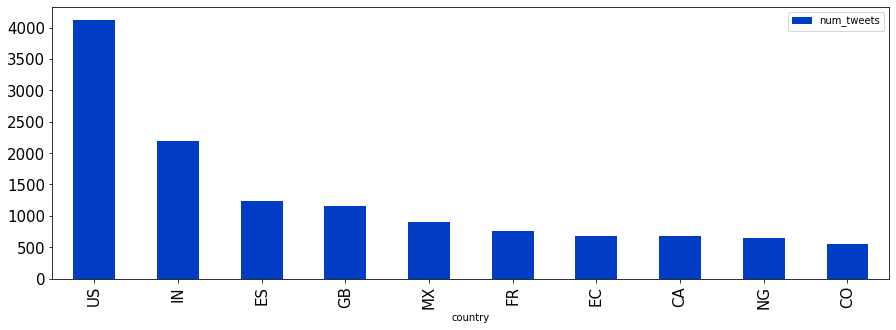

In [151]:
countryDf = pd.DataFrame(dict(df.country_code.value_counts()).items(), columns=['country', 'num_tweets'])
countryDf = countryDf[0:10]
countryDf.plot.bar(x="country", y="num_tweets", figsize=(15,5), fontsize=15, color="#013DC4")

<AxesSubplot:xlabel='date'>

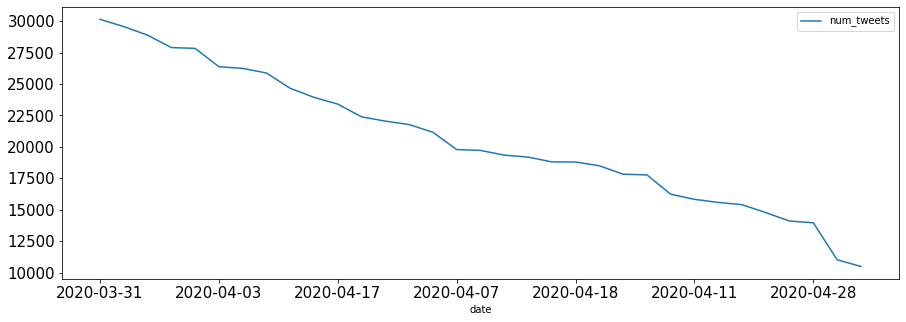

In [100]:
timeDf = df 
timeDf['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
timeDf['created_at'] = timeDf['created_at'].dt.date
timeDf['created_at'] = timeDf['created_at'].astype(str)

timeDf = pd.DataFrame(dict(timeDf['created_at'].value_counts()).items(), columns=['date', 'num_tweets'])

timeDf.plot.line(x="date", y="num_tweets", figsize=(15,5), fontsize=15)

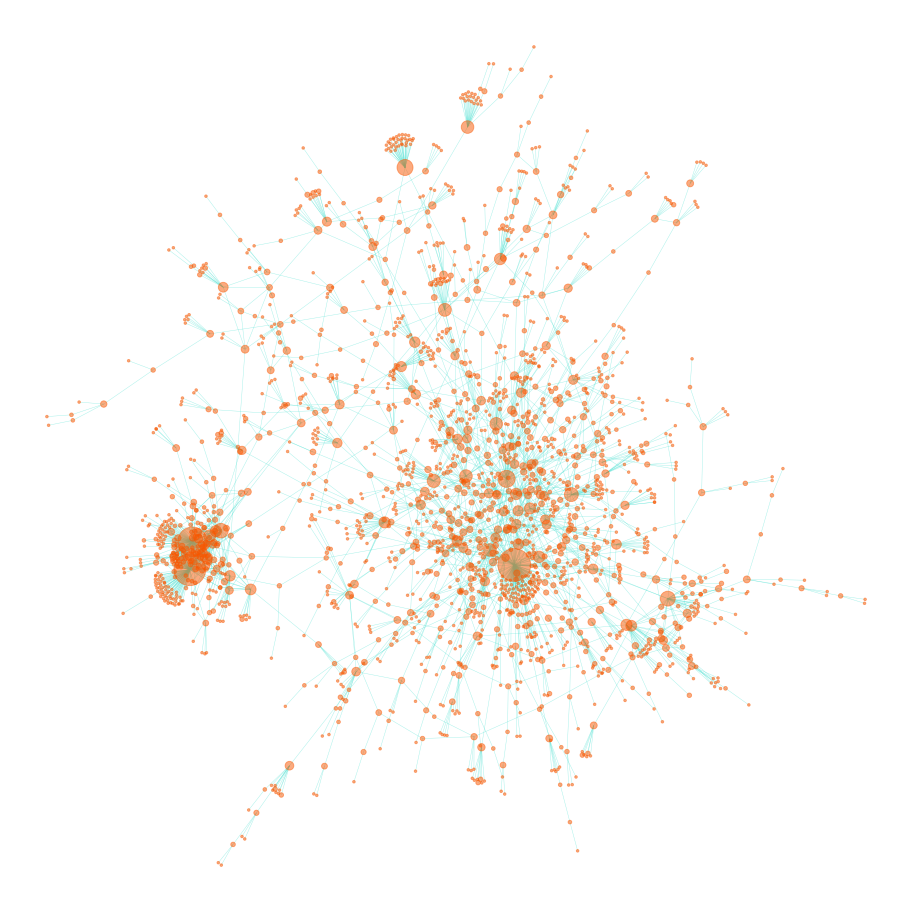

12147 16986


In [169]:
hashtag = "covid19"
edges_df = get_network(df, hashtag)
G = nx.from_pandas_edgelist(edges_df, 'from', 'to', create_using=nx.DiGraph())
Gcc = get_weakly_gcc(G)
Gcc = Gcc.to_undirected()
Gcc_degree = Gcc.degree()

plot_network(Gcc, Gcc_degree, hashtag)
print(G.number_of_nodes(), len(edges_df))
create_gephi_from_network(G, hashtag)


In [164]:
edges_df

from               to  created_at
0    Rebel_diaries_1       BPCLimited  2020-03-29
1       sanketdhende       BPCLimited  2020-03-29
2    NorthernComd_IA  NorthernComd_IA  2020-03-29
3         adkhatri26     narendramodi  2020-03-29
4       SkBloodSrini  Siva_Kartikeyan  2020-03-31
..               ...              ...         ...
469        rodmedi12  AintitMarvelous  2020-04-30
470  Upendra65831373  Atheist_Krishna  2020-04-30
471  ProfAkinAbayomi  ProfAkinAbayomi  2020-04-30
472    adgzonekanpur    adgzonekanpur  2020-04-30
473         JayGalla         JayGalla  2020-04-30

[474 rows x 3 columns]